<h1><font size=12>
Weather Derivatites </h1>
<h1> Rainfall Simulator -- Final Modelling + Pricing <br></h1>

Developed by [Jesus Solano](mailto:ja.solano588@uniandes.edu.co) <br>  
16 November 2018 


In [276]:
# Import needed libraries. 
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import gamma
import pickle
import time
import datetime
from scipy import stats


# Generate artificial Data

In [277]:
### ENSO probabilistic forecast.

# Open saved data.
ensoForecast = pickle.load(open('../../datasets/ensoForecastProb/ensoForecastProbabilities.pickle','rb'))

# Print an example .. ( Format needed)

ensoForecast['2017-01']

,Season,La Niña,Neutral,El Niño
0,JFM 2017,13%,86%,1%
1,FMA 2017,7%,90%,3%
2,MAM 2017,4%,89%,7%
3,AMJ 2017,5%,80%,15%
4,MJJ 2017,11%,63%,26%
5,JJA 2017,13%,53%,34%
6,JAS 2017,14%,48%,38%
7,ASO 2017,19%,44%,37%
8,SON 2017,22%,39%,39%


# Financial Analysis

In [278]:
def calculatePrice_Call(strikePrice, interestRate, finalSimulationData):
    
    presentValueArray = [0]*len(finalSimulationData)
    
    for i in range(len(finalSimulationData)):
        tempDiff = finalSimulationData[i]-strikePrice
        
        realDiff = max(0,tempDiff)
        
        presentValue = realDiff*np.exp(-interestRate/12)
        
        presentValueArray[i] = presentValue 
    
    #print('The option price should be: \n ' , np.mean(presentValueArray))
    return np.mean(presentValueArray)

In [279]:
def calculatePrice_Put(strikePrice, interestRate, finalSimulationData):
    
    presentValueArray = [0]*len(finalSimulationData)
    
    for i in range(len(finalSimulationData)):
        tempDiff = strikePrice - finalSimulationData[i]
        
        realDiff = max(0,tempDiff)
        
        presentValue = realDiff*np.exp(-interestRate/12)
        
        presentValueArray[i] = presentValue 
    
    #print('The option price should be: \n ' , np.mean(presentValueArray))
    return np.mean(presentValueArray)

# Final Results

In [280]:
def plotRainfallDistribution(rainfallSimulated):
  
    # Create Figure.
    fig = plt.figure(figsize=(20, 10))

    # Plot histogram.
    plt.hist(rainfallSimulated,facecolor='steelblue',bins=100, density=True,
           histtype='stepfilled', edgecolor = 'black' , hatch = '+')

    # Add axis names.
    plt.title('Rainfall Simulation')
    plt.xlabel('Rainfall Amount [mm]')
    plt.ylabel('Probability ')
    plt.grid()
    plt.show()

# Model 1 --  Basic Simulation

In [281]:
#### Define parameters simulation.

# Transitions probabilites.
monthTransitionsProb = pd.read_csv('../../results/visibleMarkov/monthTransitions.csv', index_col=0)

# Rainfall amount parameters( Gamma parameters)
fittedGamma = pd.read_csv('../../results/visibleMarkov/fittedGamma.csv', index_col=0)


### Build the simulation core.

# Updates the state of the day based on yesterday state. 
def updateState_1(yesterdayDate, yesterdayState, monthTransitions):
    
    yesterdayMonth = yesterdayDate.month
    
    successProbability = monthTransitions['p'+str(yesterdayState)+'1'][yesterdayMonth]
    
    todayState = bernoulli.rvs(successProbability)
    
    return todayState

# Simulates one run of simulation. 
def oneRun_1(daysNumber, startDate, initialState, monthTransitions,fittedGamma):
    
    # Create a variable to store the last day state.
    yesterdayState = initialState
    
    # Generate a timestamp with all days in simulation.
    dates = pd.date_range(startDate, periods=daysNumber, freq='D')
    
    # Define the total rainfall amount over the simulation.
    rainfall = 0
    
    # Loop over days in simulation to calculate rainfall ammount.
    for day in dates:
        
        # Update today state based on the yesterday state. 
        todayState = updateState_1(day-1, yesterdayState, monthTransitions)
        
        # Computes total accumulated rainfall.
        if todayState == 1:
            
            todayRainfall = gamma.rvs(fittedGamma['Shape'][0],fittedGamma['Loc'][0],fittedGamma['Scale'][0])
            
            # Updates rainfall amount. 
            rainfall += todayRainfall
        
        yesterdayState = todayState
            
        
    return rainfall

# Run total iterations.
def totalRun_1(daysNumber,startDate,initialState, monthTransitionsProb,fittedGamma,iterations):
    
    # Initialize time 
    startTime = time.time()
    
    # Array to store all precipitations.
    rainfallPerIteration = [None]*iterations
    
    # Loop over each iteration(simulation)
    
    for i in range(iterations):
        
        iterationRainfall = oneRun_1(daysNumber,startDate,initialState, monthTransitionsProb,fittedGamma)
        
        rainfallPerIteration[i] = iterationRainfall
    
    # Calculate time
    currentTime = time.time() - startTime 
    
    # Logging time.
    #print('The elapsed time over simulation is: ', currentTime, ' seconds.')
    
    return rainfallPerIteration

def optionRainfallCalculator_1(iterations, startDate,initialState, monthTransitionsProb,fittedGamma, optionMonthTerm):
  
    ## Generates initial conditions.
  
    # Defines initial state based on proportions.
    successProbability = 0.5
    initialState = bernoulli.rvs(successProbability) 

    # Calculates initial prepicipitation.
    if initialState == 1:
        initialPrep = 1.0
    else:
        initialPrep = 0.0

    ## Create dataframe to simulate. 
    simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)
    
    daysNumber = 30 
    ## Run all iterations.
    rainfallPerIteration = totalRun_1(daysNumber,startDate,initialState, monthTransitionsProb,fittedGamma,iterations)

    ## Plot histogram.

    #plotRainfallDistribution(rainfallPerIteration)

    ## Print Statistics.

    #print(stats.describe(rainfallPerIteration))

    return rainfallPerIteration

# Model 2 --  GLM Transitions + Gamma Historical Fit

In [286]:
#### Define parameters simulation.

# Transitions probabilites.
monthTransitionsProb = pd.read_csv('../../results/visibleMarkov/monthTransitions.csv', index_col=0)

# Rainfall amount parameters( Gamma parameters)
fittedGamma = pd.read_csv('../../results/visibleMarkov/fittedGamma.csv', index_col=0)


### Build the simulation core.

# Updates the state of the day based on yesterday state. 
def updateState_2(yesterdayIndex, simulationDataFrame, transitionsParametersDry, transitionsParametersWet):
    
    # Additional data of day.
    yesterdayState = simulationDataFrame['state'][yesterdayIndex]
    yesterdayPrep = simulationDataFrame['Prep'][yesterdayIndex]
    yesterdayProbNino = simulationDataFrame['probNino'][yesterdayIndex]
    yesterdayProbNina = simulationDataFrame['probNina'][yesterdayIndex]
    yesterdayMonth = simulationDataFrame['Month'][yesterdayIndex]
    
    # Calculate transition probability.
    if yesterdayState == 0:
        # Includes month factor + probNino value + probNino value.
        successProbabilityLogit = transitionsParametersDry['value'][yesterdayMonth] + yesterdayProbNino*transitionsParametersDry['value'][13] +  yesterdayProbNina*transitionsParametersDry['value'][14]

        successProbability = (np.exp(successProbabilityLogit))/(1+np.exp(successProbabilityLogit)) 
        
    elif yesterdayState == 1:
        # Includes month factor + probNino value + probNino value + prep value .
        successProbabilityLogit = transitionsParametersDry['value'][yesterdayMonth] + yesterdayProbNino*transitionsParametersWet['value'][14] +  yesterdayProbNina*transitionsParametersWet['value'][15] + yesterdayPrep*transitionsParametersWet['value'][13] 

        successProbability = (np.exp(successProbabilityLogit))/(1+np.exp(successProbabilityLogit))    
    else:
        print('State of date: ', simulationDataFrame.index[yesterdayIndex],' not found.')
    
    todayState = bernoulli.rvs(successProbability)
    
    return todayState 

# Simulates one run of simulation. 
def oneRun_2(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, fittedGamma):
    
    # Define the total rainfall amount over the simulation.
    rainfall = 0
    
    # Total rainfall days.
    wetDays = 0
    
    # Loop over days in simulation to calculate rainfall ammount.
    for day in range(1,len(simulationDataFrame)):
        
        # Get today date. 
        dateOfDay = datetime.datetime.strptime(simulationDataFrame.index[day],'%Y-%m-%d')
        indexToday = simulationDataFrame.index[day]
        # Get today date. 
        dateOfYesterday = datetime.datetime.strptime(simulationDataFrame.index[day-1],'%Y-%m-%d')
        indexYesterday = simulationDataFrame.index[day-1]
        
        # Update today state based on the yesterday state. 
        todayState = updateState_2(day-1, simulationDataFrame, transitionsParametersDry, transitionsParametersWet)
        
        # Write new day information.
        simulationDataFrame.loc[indexToday,'state'] = todayState
        simulationDataFrame.loc[indexYesterday,'nextState'] = todayState
        
        # Computes total accumulated rainfall.
        if todayState == 1:
            
            # Sum wet day.
            wetDays+=1

            
            todayRainfall = gamma.rvs(fittedGamma['Shape'][0],fittedGamma['Loc'][0],fittedGamma['Scale'][0])
            
           
            # Write new day information.
            simulationDataFrame.loc[indexToday,'Prep'] = todayRainfall
            
            # Updates rainfall amount. 
            rainfall += todayRainfall
            
        else:
            # Write new day information.
            simulationDataFrame.loc[indexToday,'Prep'] = 0
            
        
        yesterdayState = todayState   
    
    return rainfall,wetDays

# Run total iterations.
def totalRun_2(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, fittedGamma,iterations):
    
    # Initialize time 
    startTime = time.time()
    
    # Array to store all precipitations.
    rainfallPerIteration = [None]*iterations
    
    wetDaysPerIteration = [None]*iterations
    
    # Loop over each iteration(simulation)
    
    for i in range(iterations):
        
        simulationDataFrameC = simulationDataFrame.copy()
        
        iterationRainfall,wetDays = oneRun_2(simulationDataFrameC, transitionsParametersDry, transitionsParametersWet, fittedGamma)
        
        rainfallPerIteration[i] = iterationRainfall
        
        wetDaysPerIteration[i] = wetDays
    
    # Calculate time
    currentTime = time.time() - startTime 
    
    # Print mean of wet days. 
    
    #print('The mean of wet days is: ', np.mean(wetDaysPerIteration))
    
    # Logging time.
    #print('The elapsed time over simulation is: ', currentTime, ' seconds.')
    
    return rainfallPerIteration

def optionRainfallCalculator_2(iterations, startDate, transitionsParametersDry, transitionsParametersWet, fittedGamma, optionMonthTerm):
  
    ## Generates initial conditions.
  
    # Defines initial state based on proportions.
    successProbability = 0.5
    initialState = bernoulli.rvs(successProbability) 

    # Calculates initial prepicipitation.
    if initialState == 1:
        initialPrep = 1.0
    else:
        initialPrep = 0.0

    ## Create dataframe to simulate. 
    simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)

    ## Run all iterations.
    rainfallPerIteration = totalRun_2(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, fittedGamma,iterations)

    ## Plot histogram.

    #plotRainfallDistribution(rainfallPerIteration)

    ## Print Statistics.

    #print(stats.describe(rainfallPerIteration))

    return rainfallPerIteration

# Model 3 -- GLM Transitions + VGLM gamma

In [287]:
### Load transitions and amount parameters.

# Transitions probabilites.
transitionsParametersDry = pd.read_csv('../../results/visibleMarkov/transitionsParametersDry_glm.csv', sep = ' ', header=None, names = ['variable', 'value'])
transitionsParametersDry.index += 1 
transitionsParametersDry

transitionsParametersWet = pd.read_csv('../../results/visibleMarkov/transitionsParametersWet_glm.csv', sep = ' ', header=None, names = ['variable', 'value'])
transitionsParametersWet.index += 1 
transitionsParametersWet

amountParametersGamma = pd.read_csv('../../results/visibleMarkov/amountGamma_vglm.csv', sep = ' ', header=None, names = ['variable', 'mu', 'shape'])
amountParametersGamma.index += 1 

### Build the simulation core.

# Updates the state of the day based on yesterday state. 
def updateState_3(yesterdayIndex, simulationDataFrame, transitionsParametersDry, transitionsParametersWet):
    
    # Additional data of day.
    yesterdayState = simulationDataFrame['state'][yesterdayIndex]
    yesterdayPrep = simulationDataFrame['Prep'][yesterdayIndex]
    yesterdayProbNino = simulationDataFrame['probNino'][yesterdayIndex]
    yesterdayProbNina = simulationDataFrame['probNina'][yesterdayIndex]
    yesterdayMonth = simulationDataFrame['Month'][yesterdayIndex]
    
    # Calculate transition probability.
    if yesterdayState == 0:
        # Includes month factor + probNino value + probNino value.
        successProbabilityLogit = transitionsParametersDry['value'][yesterdayMonth] + yesterdayProbNino*transitionsParametersDry['value'][13] +  yesterdayProbNina*transitionsParametersDry['value'][14]

        successProbability = (np.exp(successProbabilityLogit))/(1+np.exp(successProbabilityLogit)) 
        
    elif yesterdayState == 1:
        # Includes month factor + probNino value + probNino value + prep value .
        successProbabilityLogit = transitionsParametersDry['value'][yesterdayMonth] + yesterdayProbNino*transitionsParametersWet['value'][14] +  yesterdayProbNina*transitionsParametersWet['value'][15] + yesterdayPrep*transitionsParametersWet['value'][13] 

        successProbability = (np.exp(successProbabilityLogit))/(1+np.exp(successProbabilityLogit))    
    else:
        print('State of date: ', simulationDataFrame.index[yesterdayIndex],' not found.')
    
    todayState = bernoulli.rvs(successProbability)
    
    return todayState 

# Simulates one run of simulation. 
def oneRun_3(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma):
    
    # Define the total rainfall amount over the simulation.
    rainfall = 0
    
    # Total rainfall days.
    wetDays = 0
    
    # Loop over days in simulation to calculate rainfall ammount.
    for day in range(1,len(simulationDataFrame)):
        
        # Get today date. 
        dateOfDay = datetime.datetime.strptime(simulationDataFrame.index[day],'%Y-%m-%d')
        indexToday = simulationDataFrame.index[day]
        # Get today date. 
        dateOfYesterday = datetime.datetime.strptime(simulationDataFrame.index[day-1],'%Y-%m-%d')
        indexYesterday = simulationDataFrame.index[day-1]
    
        # Update today state based on the yesterday state. 
        todayState = updateState_3(day-1, simulationDataFrame, transitionsParametersDry, transitionsParametersWet)
        
        # Write new day information.
        simulationDataFrame.loc[indexToday,'state'] = todayState
        simulationDataFrame.loc[indexYesterday,'nextState'] = todayState
        
        # Computes total accumulated rainfall.
        if todayState == 1:
            
            # Sum wet day.
            wetDays+=1
            
            # Additional data of day.
            todayProbNino = simulationDataFrame['probNino'][day]
            todayProbNina = simulationDataFrame['probNina'][day]
            todayMonth = simulationDataFrame['Month'][day]
            
            # Calculates gamma log(mu).
            gammaLogMu = amountParametersGamma['mu'][todayMonth]+ todayProbNino*amountParametersGamma['mu'][13]+todayProbNina*amountParametersGamma['mu'][14] 
            #print(gammaMu)
            # Calculates gamma scale
            gammaLogShape = amountParametersGamma['shape'][todayMonth]+ todayProbNino*amountParametersGamma['shape'][13]+todayProbNina*amountParametersGamma['shape'][14]
            #print(gammaShape)
                 
            # Update mu
            gammaMu = np.exp(gammaLogMu)
            
            # Update shape
            gammaShape = np.exp(gammaLogShape)
            
            # Calculate gamma scale.
            gammaScale = gammaMu / gammaShape
            
            # Generate random rainfall.
            todayRainfall = gamma.rvs(a = gammaShape, scale = gammaScale)    
            
            # Write new day information.
            simulationDataFrame.loc[indexToday,'Prep'] = todayRainfall
            
            # Updates rainfall amount. 
            rainfall += todayRainfall
            
        else:
            # Write new day information.
            simulationDataFrame.loc[indexToday,'Prep'] = 0
            
        
        yesterdayState = todayState
            
    return rainfall,wetDays

# Run total iterations.
def totalRun_3(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations):
    
    # Initialize time 
    startTime = time.time()
    
    # Array to store all precipitations.
    rainfallPerIteration = [None]*iterations
    
    wetDaysPerIteration = [None]*iterations
    
    # Loop over each iteration(simulation)
    
    for i in range(iterations):
        
        simulationDataFrameC = simulationDataFrame.copy()
        
        iterationRainfall,wetDays = oneRun_3(simulationDataFrameC, transitionsParametersDry, transitionsParametersWet, amountParametersGamma)
        
        rainfallPerIteration[i] = iterationRainfall
        
        wetDaysPerIteration[i] = wetDays
    
    # Calculate time
    currentTime = time.time() - startTime 
    
    # Print mean of wet days. 
    
    #print('The mean of wet days is: ', np.mean(wetDaysPerIteration))
    
    # Logging time.
    #print('The elapsed time over simulation is: ', currentTime, ' seconds.')
    
    return rainfallPerIteration

def optionRainfallCalculator_3(iterations, startDate, transitionsParametersDry, transitionsParametersWet, amountParametersGamma, optionMonthTerm):
  
    ## Generates initial conditions.
  
    # Defines initial state based on proportions.
    successProbability = 0.5
    initialState = bernoulli.rvs(successProbability) 

    # Calculates initial prepicipitation.
    if initialState == 1:
        initialPrep = 1.0
    else:
        initialPrep = 0.0

    ## Create dataframe to simulate. 
    simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)

    ## Run all iterations.
    rainfallPerIteration = totalRun_3(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)

    ## Plot histogram.

    #plotRainfallDistribution(rainfallPerIteration)

    ## Print Statistics.

    #print(stats.describe(rainfallPerIteration))

    return rainfallPerIteration

In [288]:
np.mean(optionRainfallCalculator_1(iterations=500,
                           startDate='2017-10-01',
                           initialState= 0 ,
                           monthTransitionsProb=monthTransitionsProb,
                           fittedGamma=fittedGamma, 
                           optionMonthTerm=1))

81.2328374753549

In [289]:
np.mean(optionRainfallCalculator_2(iterations=500,
                           startDate='2017-10-01',
                           transitionsParametersDry= transitionsParametersDry ,
                           transitionsParametersWet = transitionsParametersWet,
                           fittedGamma=fittedGamma, 
                           optionMonthTerm=1))

98.44694992112281

In [290]:
np.mean(optionRainfallCalculator_3(iterations=500,
                           startDate='2017-10-01',
                           transitionsParametersDry= transitionsParametersDry ,
                           transitionsParametersWet = transitionsParametersWet,
                           amountParametersGamma=amountParametersGamma, 
                           optionMonthTerm=1))

176.59518241666694

# Plotting final results

In [37]:
def finalComparison(iterations, startDate, transitionsParametersDry, transitionsParametersWet, amountParametersGamma, strikePrices, interestRates):
    start= time.time()
    fig = plt.figure(figsize=(20, 10))
    for strikePrice in strikePrices:
        rainfallOptionTo={}
        pricePerOption =  {}
        for optionMonthTerm in range(1,8):
            rainfallOptionTo[optionMonthTerm] = optionRainfallCalculator(iterations, startDate, transitionsParametersDry, transitionsParametersWet, amountParametersGamma, optionMonthTerm)
            interestRate = interestRates
            pricePerOption[optionMonthTerm] = calculatePrice_Call(strikePrice, interestRate, rainfallOptionTo[optionMonthTerm])
        
        plotList = list(pricePerOption.values())
        
        # Create Figure.
        

        '''
        # Plot histogram.
        plt.hist(rainfallSimulated,facecolor='steelblue',bins=100, density=True,
               histtype='stepfilled', edgecolor = 'black' , hatch = '+')
        '''
        x = range(1,8)
        
        plt.plot(x,plotList, label='Strike Price ='+ str(strikePrice))
        
    # Add axis names.
    plt.title('Rainfall Option Simulation')
    plt.xlabel('Month')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()
    print('Elapsed time was: ',time.time()-start)

In [ ]:
def strikePricesComparison(iterations, startDate, transitionsParametersDry, transitionsParametersWet, amountParametersGamma, strikePrices, interestRates):
    start= time.time()
    fig = plt.figure(figsize=(20, 10))
    
    for strikePrice in strikePrices:
        rainfallOptionTo={}
        pricePerOption =  {}
        for optionMonthTerm in range(1,8):
            rainfallOptionTo[optionMonthTerm] = optionRainfallCalculator(iterations, startDate, transitionsParametersDry, transitionsParametersWet, amountParametersGamma, optionMonthTerm)
            interestRate = interestRates
            pricePerOption[optionMonthTerm] = calculatePrice_Call(strikePrice, interestRate, rainfallOptionTo[optionMonthTerm])
        
        plotList = list(pricePerOption.values())
        
        # Create Figure.
        

        '''
        # Plot histogram.
        plt.hist(rainfallSimulated,facecolor='steelblue',bins=100, density=True,
               histtype='stepfilled', edgecolor = 'black' , hatch = '+')
        '''
        x = range(1,8)
        
        plt.plot(x,plotList, label='Strike Price ='+ str(strikePrice))
        
    # Add axis names.
    plt.title('Rainfall Call Option Simulation')
    plt.xlabel('Month')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()
    print('Elapsed time was: ',time.time()-start)

In [38]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

def finalComparisonGraph(iterations, startDate, transitionsParametersDry, transitionsParametersWet, amountParametersGamma, strikePrices, interestRates):
    
    plt.figure(figsize=(20, 10))
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)
    count =1
    
    for strikePrice in strikePrices:
        rainfallOptionTo={}
        pricePerOption =  {}
        for optionMonthTerm in range(1,8):
            rainfallOptionTo[optionMonthTerm] = optionRainfallCalculator(iterations, startDate, transitionsParametersDry, transitionsParametersWet, amountParametersGamma, optionMonthTerm)
            interestRate = interestRates
            pricePerOption[optionMonthTerm] = calculatePrice(strikePrice, interestRate, rainfallOptionTo[optionMonthTerm])
        
        
        plotList = list(pricePerOption.values())
        
        # Create Figure.
        par = host.twinx()
        
        offset = 45
        new_fixed_axis = par.get_grid_helper().new_fixed_axis
        par.axis["right"] = new_fixed_axis(loc="right", axes=par,
                                        offset=(offset*count, 0))
        
        par.axis["right"].toggle(all=True)
        
        par.set_ylabel('Price')
        '''
        # Plot histogram.
        plt.hist(rainfallSimulated,facecolor='steelblue',bins=100, density=True,
               histtype='stepfilled', edgecolor = 'black' , hatch = '+')
        '''
        x = range(1,8)
        
        p, =par.plot(x,plotList, label='Strike Price ='+ str(strikePrice))
        
        par.axis['right'].label.set_color(p.get_color())
        
        count+=1
    # Add axis names.
    plt.title('Rainfall Option Simulation')
    plt.xlabel('Month')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

In [39]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

def finalComparisonGraph_S(iterations, startDate,initialState, monthTransitionsProb,fittedGamma, strikePrices, interestRates):
    
    plt.figure(figsize=(20, 10))
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)
    count =1
    
    for strikePrice in strikePrices:
        rainfallOptionTo={}
        pricePerOption =  {}
        for optionMonthTerm in range(1,8):
            rainfallOptionTo[optionMonthTerm] = optionRainfallCalculator_S(iterations, startDate, transitionsParametersDry, transitionsParametersWet, amountParametersGamma, optionMonthTerm)
            interestRate = interestRates
            pricePerOption[optionMonthTerm] = calculatePrice(strikePrice, interestRate, rainfallOptionTo[optionMonthTerm])
        
        
        plotList = list(pricePerOption.values())
        
        # Create Figure.
        par = host.twinx()
        
        offset = 45
        new_fixed_axis = par.get_grid_helper().new_fixed_axis
        par.axis["right"] = new_fixed_axis(loc="right", axes=par,
                                        offset=(offset*count, 0))
        
        par.axis["right"].toggle(all=True)
        
        par.set_ylabel('Price')
        '''
        # Plot histogram.
        plt.hist(rainfallSimulated,facecolor='steelblue',bins=100, density=True,
               histtype='stepfilled', edgecolor = 'black' , hatch = '+')
        '''
        x = range(1,8)
        
        p, =par.plot(x,plotList, label='Strike Price ='+ str(strikePrice))
        
        par.axis['right'].label.set_color(p.get_color())
        
        count+=1
    # Add axis names.
    plt.title('Rainfall Option Simulation')
    plt.xlabel('Month')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

/home/jesus/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


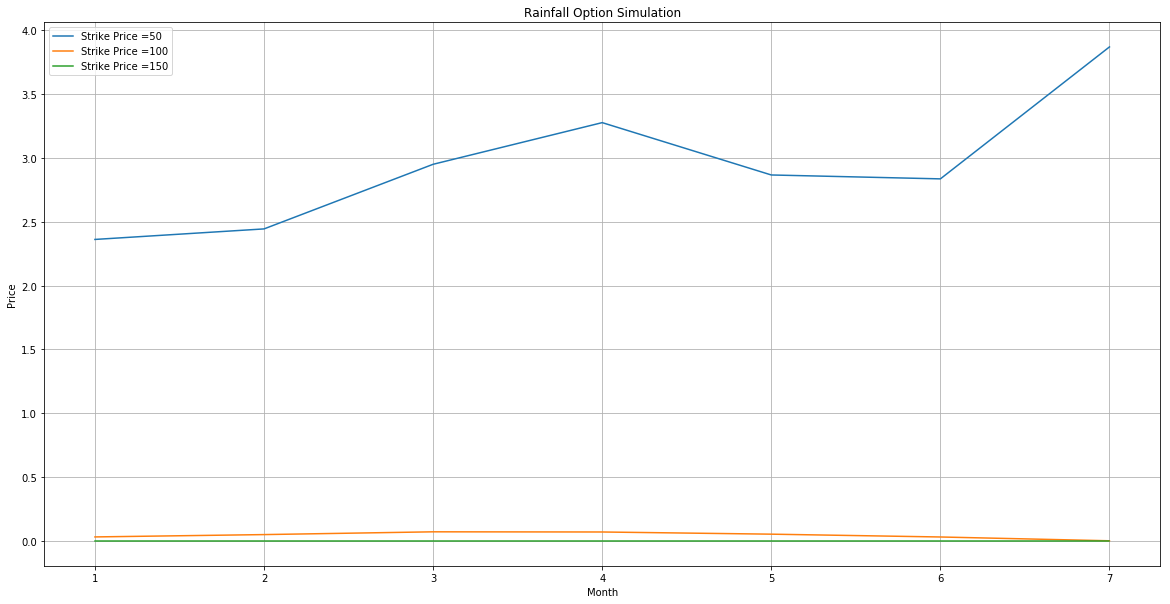

Elapsed time was:  135.8374011516571


In [40]:
strikePrices = [50,100,150]
finalComparison(iterations=500,
                  startDate='2017-01-01',
                  transitionsParametersDry= transitionsParametersDry ,
                  transitionsParametersWet = transitionsParametersWet,
                  amountParametersGamma = amountParametersGamma,
                  strikePrices=strikePrices,
                  interestRates= 0.0235 )

In [291]:
# Simulate final call and put price. 

def makeOptionTable(iterations,models, months, strikePrices, year, interestRate ,optionMonthTerm,):
    startTime=datetime.datetime.now()
    
    iterables = [months,strikePrices]
    rows = pd.MultiIndex.from_product(iterables, names=['Month', 'Strike'])

    iterables = [ models , ['Call', 'Put'] ]
    cols = pd.MultiIndex.from_product(iterables, names=['Model', 'Option'])  
    
    dfSummary = pd.DataFrame(0, columns=cols,index=rows)
    
    for model in models:
        for month in months:
            strMonth = '{:02}'.format(strptime(month,'%b').tm_mon)
            startDate =  str(year)+'-'+strMonth+'-01'
            if model == 'Model 1':
                finalSimulationData = optionRainfallCalculator_1(iterations=iterations,
                                                   startDate=startDate,
                                                   initialState= 0 ,
                                                   monthTransitionsProb=monthTransitionsProb,
                                                   fittedGamma=fittedGamma, 
                                                   optionMonthTerm=optionMonthTerm)
            elif model == 'Model 2':
                finalSimulationData = optionRainfallCalculator_2(iterations=iterations,
                                                   startDate=startDate,
                                                   transitionsParametersDry= transitionsParametersDry ,
                                                   transitionsParametersWet = transitionsParametersWet,
                                                   fittedGamma=fittedGamma, 
                                                   optionMonthTerm=optionMonthTerm)
            elif model == 'Model 3':
                finalSimulationData = optionRainfallCalculator_3(iterations=iterations,
                                                   startDate=startDate,
                                                   transitionsParametersDry= transitionsParametersDry ,
                                                   transitionsParametersWet = transitionsParametersWet,
                                                   amountParametersGamma=amountParametersGamma, 
                                                   optionMonthTerm=optionMonthTerm)
            else:
                print('The requested model does not exist.')
                
            for strikePrice in strikePrices :
                # Fill Call Option.
                dfSummary.loc[(month,strikePrice),(model,'Call')] = float('{0:.2f}'.format(calculatePrice_Call(strikePrice, interestRate, finalSimulationData)))
                # Fill Put  Option.
                dfSummary.loc[(month,strikePrice),(model,'Put')] = float('{0:.2f}'.format(calculatePrice_Put(strikePrice, interestRate, finalSimulationData)))
    
    print('The elapsed time was: ', datetime.datetime.now()-startTime)
    return dfSummary

In [292]:
oneMonthTable = makeOptionTable(iterations=500,
                models=['Model 1','Model 2','Model 3'],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                strikePrices=[50,100,150],
                year = 2017,
                interestRate = 0.0234,  
                optionMonthTerm=1)

The elapsed time was:  0:05:52.179918


In [293]:
oneMonthTable

Model        Model 1         Model 2         Model 3        
Option          Call     Put    Call     Put    Call     Put
Month Strike                                                
Jan   50        3.46   19.47    2.76   19.86    2.17   20.57
      100       0.31   66.23    0.11   67.11    0.00   68.30
      150       0.02  115.83    0.00  116.90    0.00  118.21
Feb   50       11.17    8.98    5.88   12.97    8.99   10.74
      100       0.76   48.47    0.10   57.10    0.53   52.18
      150       0.08   97.69    0.00  106.90    0.00  101.55
Mar   50       19.74    4.44   14.19    6.31   27.82    3.05
      100       1.88   36.48    1.11   43.14    5.13   30.26
      150       0.04   84.54    0.01   91.93    0.52   75.55
Apr   50       38.11    0.94   32.51    1.31   60.58    0.30
      100       7.90   20.64    4.88   23.58   20.78   10.40
      150       0.61   63.25    0.14   68.74    4.07   43.59
May   50       40.73    0.46   33.53    1.26   39.47    0.60
      100       7.83   17.47    5.10   22.74    8.14   19.17
      150       0.38   59.92    0.20   67.74    0.84   61.77
Jun   50       35.87    1.20   20.41    3.65    8.63    7.50
      100       5.86   21.09    1.63   34.78    0.22   48.99
      150       0.46   65.59    0.07   83.11    0.00   98.67
Jul   50       27.01    2.06   27.10    2.26    5.25    9.35
      100       3.27   28.23    3.25   28.31    0.04   54.04
      150       0.10   74.96    0.16   75.12    0.00  103.90
Aug   50       25.12    2.25   31.21    1.39    9.86    5.56
      100       2.56   29.59    4.91   24.99    0.13   45.74
      150       0.00   76.94    0.32   70.31    0.00   95.51
Sep   50       24.70    2.67   21.46    3.22   20.09    2.99
      100       3.05   30.92    2.17   33.83    1.52   34.32
      150       0.12   77.89    0.06   81.63    0.00   82.70
Oct   50       32.67    1.36   49.26    0.23  127.50    0.04
      100       5.17   23.76   11.75   12.63   78.87    1.32
      150       0.22   68.72    1.04   51.82   37.11    9.46
Nov   50       29.83    1.93   42.39    0.71  105.46    0.02
      100       4.30   26.30    9.77   18.00   57.76    2.23
      150       0.18   72.09    0.70   58.83   22.11   16.48
Dec   50       13.18    7.48   18.52    5.17   37.03    1.81
      100       0.93   45.14    2.44   38.99    8.82   23.51
      150       0.01   94.11    0.09   86.55    1.52   66.11

In [294]:
threeMonthTable = makeOptionTable(iterations=500,
                models=['Model 1','Model 2','Model 3'],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                strikePrices=[50,100,150],
                year = 2017,
                interestRate = 0.0234,  
                optionMonthTerm=1)
threeMonthTable

The elapsed time was:  0:05:47.693546


Model        Model 1         Model 2         Model 3        
Option          Call     Put    Call     Put    Call     Put
Month Strike                                                
Jan   50        3.94   18.01    2.81   20.15    1.83   20.87
      100       0.15   64.12    0.02   67.27    0.02   68.96
      150       0.00  113.87    0.00  117.15    0.00  118.84
Feb   50       11.07    8.59    7.01   12.95   10.42    9.41
      100       0.86   48.29    0.41   56.25    0.97   49.87
      150       0.04   97.36    0.00  105.75    0.03   98.83
Mar   50       20.10    4.00   13.68    6.40   24.88    3.76
      100       1.78   35.59    1.50   44.13    3.80   32.58
      150       0.03   83.74    0.05   92.58    0.15   78.84
Apr   50       36.54    0.65   31.00    1.54   60.21    0.40
      100       5.42   19.43    4.58   25.02   20.78   10.87
      150       0.26   64.18    0.22   70.56    4.04   44.03
May   50       39.43    0.90   34.47    1.18   36.97    0.93
      100       7.26   18.63    5.22   21.84    6.26   20.12
      150       0.46   61.74    0.21   66.72    0.25   64.01
Jun   50       39.32    0.78   21.58    3.45    6.81    7.64
      100       6.82   18.19    2.11   33.88    0.11   50.84
      150       0.32   61.59    0.00   81.68    0.00  100.64
Jul   50       29.24    1.31   25.86    2.34    5.48    8.50
      100       3.64   25.61    3.32   29.70    0.05   52.97
      150       0.02   71.89    0.15   76.43    0.00  102.83
Aug   50       24.19    2.28   31.08    1.55   10.05    4.06
      100       2.88   30.88    4.15   24.52    0.22   44.13
      150       0.14   78.04    0.14   70.42    0.00   93.81
Sep   50       23.17    3.10   24.14    2.79   20.56    3.41
      100       2.87   32.70    3.06   31.62    1.76   34.52
      150       0.19   79.93    0.22   78.68    0.10   82.76
Oct   50       31.18    1.44   46.44    0.27  129.37    0.00
      100       4.82   24.97    9.74   13.47   80.03    0.56
      150       0.15   70.21    0.41   54.04   38.49    8.92
Nov   50       32.33    1.17   40.89    0.66  104.65    0.05
      100       4.95   23.70    7.52   17.19   57.01    2.31
      150       0.20   68.85    0.47   60.04   21.54   16.75
Dec   50       12.37    7.53   18.37    5.05   40.66    1.61
      100       0.94   46.00    1.55   38.14    9.71   20.56
      150       0.00   94.97    0.05   86.54    0.92   61.68

In [295]:
sixMonthTable = makeOptionTable(iterations=500,
                models=['Model 1','Model 2','Model 3'],
                months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                strikePrices=[50,100,150],
                year = 2017,
                interestRate = 0.0234,  
                optionMonthTerm=1)
sixMonthTable

The elapsed time was:  0:05:46.287340


Model        Model 1         Model 2         Model 3        
Option          Call     Put    Call     Put    Call     Put
Month Strike                                                
Jan   50        3.11   18.51    2.68   19.55    2.06   19.25
      100       0.13   65.44    0.07   66.85    0.00   67.09
      150       0.00  115.21    0.00  116.68    0.00  116.99
Feb   50       11.89    7.96    5.64   12.41    9.14   11.34
      100       0.48   46.44    0.05   56.72    0.66   52.76
      150       0.00   95.87    0.00  106.58    0.01  102.01
Mar   50       19.73    4.33   13.51    6.10   24.48    3.50
      100       2.03   36.53    0.96   43.46    3.40   32.33
      150       0.13   84.53    0.00   92.40    0.42   79.25
Apr   50       37.13    0.95   35.28    1.14   63.67    0.28
      100       6.26   19.99    6.24   22.00   23.91   10.43
      150       0.37   63.99    0.56   66.22    5.20   41.62
May   50       36.92    0.68   37.11    1.05   38.87    0.88
      100       6.84   20.51    7.42   21.26    7.38   19.30
      150       0.68   64.25    0.88   64.62    0.46   62.28
Jun   50       34.55    1.02   21.69    3.41    7.79    7.74
      100       5.31   21.69    2.60   34.21    0.07   49.92
      150       0.22   66.50    0.10   81.62    0.00   99.75
Jul   50       31.40    1.39   27.96    2.05    4.39    9.92
      100       5.22   25.11    4.08   28.07    0.02   55.45
      150       0.33   70.12    0.14   74.02    0.00  105.33
Aug   50       24.93    2.20   32.99    1.30    9.75    5.03
      100       2.78   29.95    4.76   22.98    0.20   45.39
      150       0.02   77.09    0.26   68.38    0.00   95.09
Sep   50       23.26    3.21   24.45    2.82   20.31    3.64
      100       2.40   32.26    3.20   31.47    2.20   35.43
      150       0.02   79.78    0.25   78.43    0.05   83.18
Oct   50       31.66    1.35   47.18    0.25  124.71    0.00
      100       4.73   24.32   10.67   13.64   76.14    1.33
      150       0.10   69.58    1.07   53.95   35.60   10.70
Nov   50       31.18    1.53   43.24    0.41  107.27    0.00
      100       4.01   24.27    9.40   16.48   58.54    1.18
      150       0.07   70.23    0.85   57.83   22.36   14.90
Dec   50       12.92    7.22   17.10    5.50   37.89    1.59
      100       1.19   45.39    1.72   40.03    9.75   23.35
      150       0.01   94.12    0.08   88.28    1.39   64.90

# Exporting results to Latex

In [300]:
print(oneMonthTable.to_latex(bold_rows=True, multicolumn_format='c',multirow=True))

\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Model} & \multicolumn{2}{c}{Model 1} & \multicolumn{2}{c}{Model 2} & \multicolumn{2}{c}{Model 3} \\
    & \textbf{Option} &    Call &     Put &    Call &     Put &    Call &     Put \\
\textbf{Month} & \textbf{Strike} &         &         &         &         &         &         \\
\midrule
\multirow{3}{*}{\textbf{Jan}} & \textbf{50 } &    3.46 &   19.47 &    2.76 &   19.86 &    2.17 &   20.57 \\
    & \textbf{100} &    0.31 &   66.23 &    0.11 &   67.11 &    0.00 &   68.30 \\
    & \textbf{150} &    0.02 &  115.83 &    0.00 &  116.90 &    0.00 &  118.21 \\
\cline{1-8}
\multirow{3}{*}{\textbf{Feb}} & \textbf{50 } &   11.17 &    8.98 &    5.88 &   12.97 &    8.99 &   10.74 \\
    & \textbf{100} &    0.76 &   48.47 &    0.10 &   57.10 &    0.53 &   52.18 \\
    & \textbf{150} &    0.08 &   97.69 &    0.00 &  106.90 &    0.00 &  101.55 \\
\cline{1-8}
\multirow{3}{*}{\textbf{Mar}} & \textbf{50 } &   19.74 &    4.44 &   14.19 &    6.31 &   27.8

In [301]:
print(threeMonthTable.to_latex(bold_rows=True, multicolumn_format='c',multirow=True))

\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Model} & \multicolumn{2}{c}{Model 1} & \multicolumn{2}{c}{Model 2} & \multicolumn{2}{c}{Model 3} \\
    & \textbf{Option} &    Call &     Put &    Call &     Put &    Call &     Put \\
\textbf{Month} & \textbf{Strike} &         &         &         &         &         &         \\
\midrule
\multirow{3}{*}{\textbf{Jan}} & \textbf{50 } &    3.94 &   18.01 &    2.81 &   20.15 &    1.83 &   20.87 \\
    & \textbf{100} &    0.15 &   64.12 &    0.02 &   67.27 &    0.02 &   68.96 \\
    & \textbf{150} &    0.00 &  113.87 &    0.00 &  117.15 &    0.00 &  118.84 \\
\cline{1-8}
\multirow{3}{*}{\textbf{Feb}} & \textbf{50 } &   11.07 &    8.59 &    7.01 &   12.95 &   10.42 &    9.41 \\
    & \textbf{100} &    0.86 &   48.29 &    0.41 &   56.25 &    0.97 &   49.87 \\
    & \textbf{150} &    0.04 &   97.36 &    0.00 &  105.75 &    0.03 &   98.83 \\
\cline{1-8}
\multirow{3}{*}{\textbf{Mar}} & \textbf{50 } &   20.10 &    4.00 &   13.68 &    6.40 &   24.8

In [302]:
print(sixMonthTable.to_latex(bold_rows=True, multicolumn_format='c',multirow=True))

\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Model} & \multicolumn{2}{c}{Model 1} & \multicolumn{2}{c}{Model 2} & \multicolumn{2}{c}{Model 3} \\
    & \textbf{Option} &    Call &     Put &    Call &     Put &    Call &     Put \\
\textbf{Month} & \textbf{Strike} &         &         &         &         &         &         \\
\midrule
\multirow{3}{*}{\textbf{Jan}} & \textbf{50 } &    3.11 &   18.51 &    2.68 &   19.55 &    2.06 &   19.25 \\
    & \textbf{100} &    0.13 &   65.44 &    0.07 &   66.85 &    0.00 &   67.09 \\
    & \textbf{150} &    0.00 &  115.21 &    0.00 &  116.68 &    0.00 &  116.99 \\
\cline{1-8}
\multirow{3}{*}{\textbf{Feb}} & \textbf{50 } &   11.89 &    7.96 &    5.64 &   12.41 &    9.14 &   11.34 \\
    & \textbf{100} &    0.48 &   46.44 &    0.05 &   56.72 &    0.66 &   52.76 \\
    & \textbf{150} &    0.00 &   95.87 &    0.00 &  106.58 &    0.01 &  102.01 \\
\cline{1-8}
\multirow{3}{*}{\textbf{Mar}} & \textbf{50 } &   19.73 &    4.33 &   13.51 &    6.10 &   24.4

In [288]:
np.mean(optionRainfallCalculator_1(iterations=500,
                           startDate='2017-10-01',
                           initialState= 0 ,
                           monthTransitionsProb=monthTransitionsProb,
                           fittedGamma=fittedGamma, 
                           optionMonthTerm=1))

81.2328374753549

In [289]:
np.mean(optionRainfallCalculator_2(iterations=500,
                           startDate='2017-10-01',
                           transitionsParametersDry= transitionsParametersDry ,
                           transitionsParametersWet = transitionsParametersWet,
                           fittedGamma=fittedGamma, 
                           optionMonthTerm=1))

98.44694992112281

In [290]:
np.mean(optionRainfallCalculator_3(iterations=500,
                           startDate='2017-10-01',
                           transitionsParametersDry= transitionsParametersDry ,
                           transitionsParametersWet = transitionsParametersWet,
                           amountParametersGamma=amountParametersGamma, 
                           optionMonthTerm=1))

176.59518241666694

In [393]:
# Load historical month rainfall.
file = open('../../datasets/historicalMonths.pk','rb')
historicalMonths = pickle.load(file)
file.close()

def plotRainfallDistributionMonth(rainfallSimulated,month,colorP):
  
    # Create Figure.
    fig = plt.figure(figsize=(12, 8))

    # Plot Histogram
    plt.hist(historicalMonths.iloc[:,month-1].values,facecolor='grey',bins=30, density=True,
           histtype='stepfilled', edgecolor = 'black' , hatch = '', alpha = 0.5, label=' Historical Values')
    
    # Plot histogram.
    plt.hist(rainfallSimulated,facecolor=colorP,bins=100, density=True,
           histtype='stepfilled', edgecolor = 'black' , hatch = '+', alpha = 0.5, label=' Simulated Values ')
    


    # Add axis names.
    plt.title('Rainfall Simulation')
    plt.xlabel('Rainfall Amount [mm]')
    plt.ylabel('Probability ')
    plt.grid()
    plt.legend(fontsize='large')
    plt.show()

def optionRainfallCalculator_model_Plot(iterations, model , startDate, transitionsParametersDry, transitionsParametersWet, amountParametersGamma, fittedGamma, optionMonthTerm):
  
    ## Generates initial conditions.
  
    # Defines initial state based on proportions.
    successProbability = 0.5
    initialState = bernoulli.rvs(successProbability) 

    # Calculates initial prepicipitation.
    if initialState == 1:
        initialPrep = 1.0
    else:
        initialPrep = 0.0

    ## Create dataframe to simulate. 
    simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)

    ## Run all iterations.
    if model == 'Model 1':
        ## Create dataframe to simulate. 
        simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)

        daysNumber = 30 
        ## Run all iterations.
        rainfallPerIteration = totalRun_1(daysNumber,startDate,initialState, monthTransitionsProb,fittedGamma,iterations)
        colorP = 'darkred'

    elif model == 'Model 2':
        ## Create dataframe to simulate. 
        simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)

        ## Run all iterations.
        rainfallPerIteration = totalRun_2(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, fittedGamma,iterations)
        colorP = 'darkgreen'
        
    elif model == 'Model 3':
        ## Create dataframe to simulate. 
        simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)

        ## Run all iterations.
        rainfallPerIteration = totalRun_3(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)
        colorP = 'darkblue'
        
    else:
        print('The requested model does not exist.')
  
    ## Plot histogram.
    month = datetime.datetime.strptime(startDate,'%Y-%m-%d').month
    plotRainfallDistributionMonth(rainfallPerIteration,month,colorP)

    ## Print Statistics.

    print(stats.describe(rainfallPerIteration))

    return rainfallPerIteration

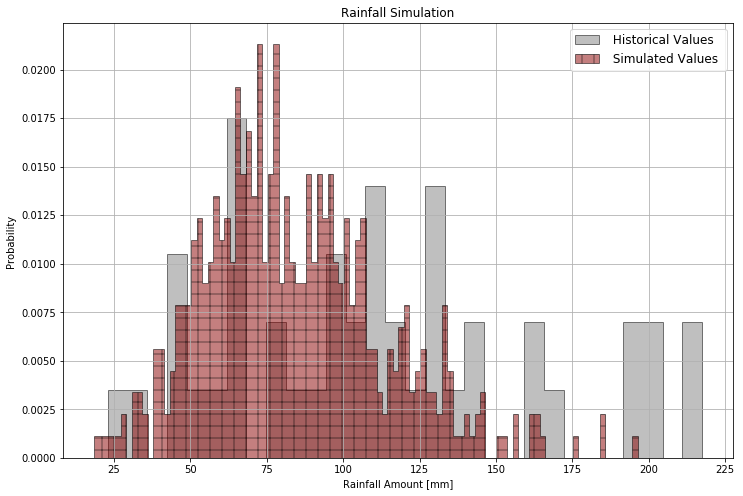

DescribeResult(nobs=500, minmax=(18.339398297388474, 196.42475664041694), mean=83.79943081579266, variance=862.2144398654804, skewness=0.6528946934542628, kurtosis=0.575121433869604)


In [367]:
myPlot= optionRainfallCalculator_model_Plot(iterations=500,
                           model='Model 1', 
                           startDate='2017-04-01',
                           transitionsParametersDry= transitionsParametersDry ,
                           transitionsParametersWet = transitionsParametersWet,
                           amountParametersGamma=amountParametersGamma,
                           fittedGamma = fittedGamma,
                           optionMonthTerm=1)

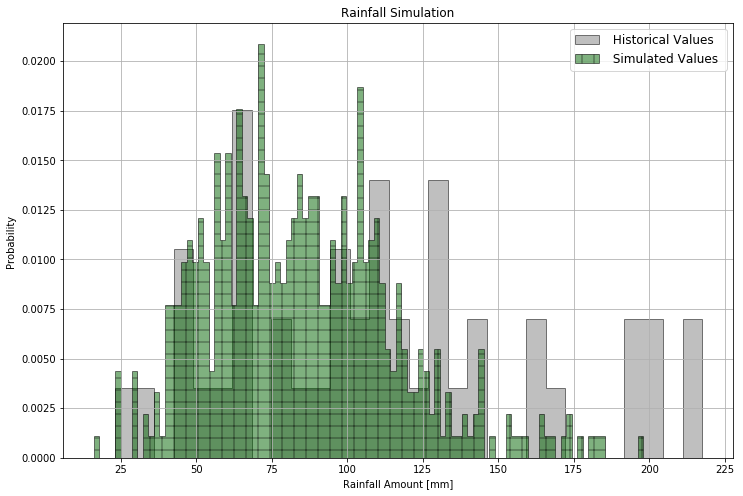

DescribeResult(nobs=500, minmax=(15.953758297787232, 197.94810017209272), mean=84.43516160279295, variance=952.3762750840386, skewness=0.6622311489417, kurtosis=0.5335231276729129)


In [368]:
myPlot= optionRainfallCalculator_model_Plot(iterations=500,
                           model='Model 2', 
                           startDate='2017-04-01',
                           transitionsParametersDry= transitionsParametersDry ,
                           transitionsParametersWet = transitionsParametersWet,
                           amountParametersGamma=amountParametersGamma,
                           fittedGamma = fittedGamma,
                           optionMonthTerm=1)

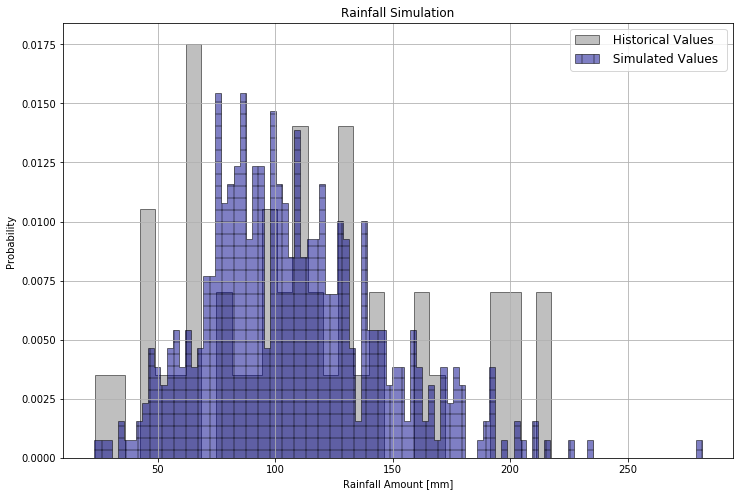

DescribeResult(nobs=500, minmax=(22.5431157932568, 281.8331274483157), mean=107.3137185804331, variance=1417.075479444036, skewness=0.7087376060556322, kurtosis=0.8888907708793283)


In [370]:
myPlot= optionRainfallCalculator_model_Plot(iterations=500,
                           model='Model 3', 
                           startDate='2017-04-01',
                           transitionsParametersDry= transitionsParametersDry ,
                           transitionsParametersWet = transitionsParametersWet,
                           amountParametersGamma=amountParametersGamma,
                           fittedGamma = fittedGamma,
                           optionMonthTerm=1)

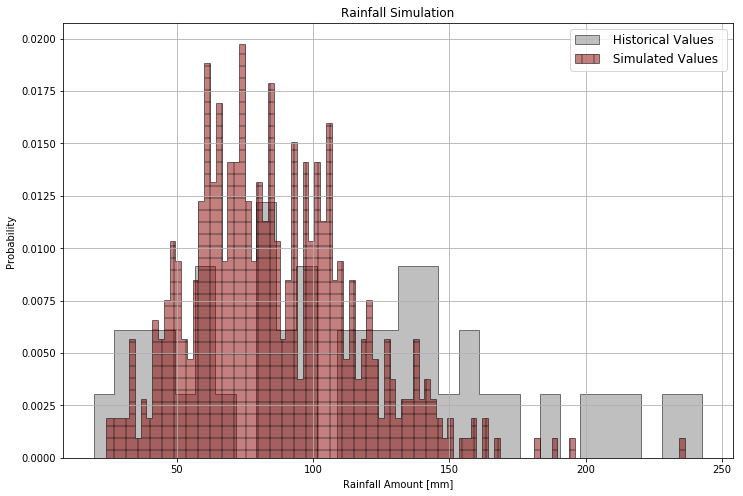

DescribeResult(nobs=500, minmax=(23.91983487403668, 236.42593999605845), mean=85.63939423045717, variance=919.4985511050928, skewness=0.7067819773239807, kurtosis=1.107224373646572)


In [394]:
myPlot= optionRainfallCalculator_model_Plot(iterations=500,
                           model='Model 1', 
                           startDate='2017-04-01',
                           transitionsParametersDry= transitionsParametersDry ,
                           transitionsParametersWet = transitionsParametersWet,
                           amountParametersGamma=amountParametersGamma,
                           fittedGamma = fittedGamma,
                           optionMonthTerm=1)

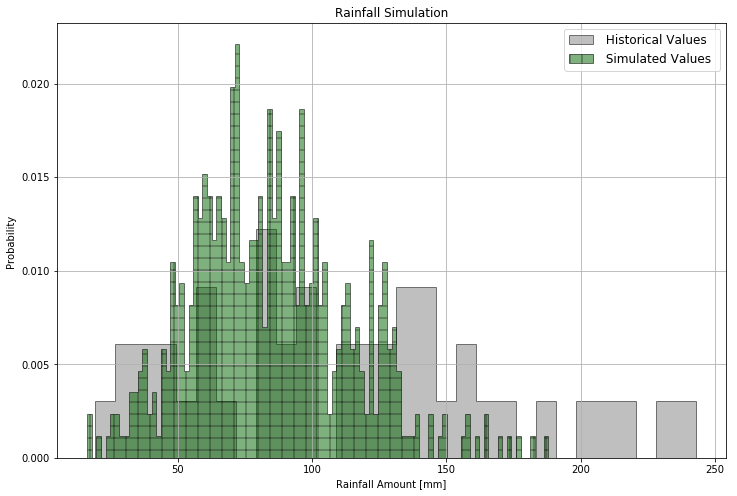

DescribeResult(nobs=500, minmax=(16.308367822931263, 187.93292475157227), mean=84.1379493077122, variance=866.4919825441224, skewness=0.50050225065572, kurtosis=0.309145143330412)


In [395]:
myPlot= optionRainfallCalculator_model_Plot(iterations=500,
                           model='Model 2', 
                           startDate='2017-04-01',
                           transitionsParametersDry= transitionsParametersDry ,
                           transitionsParametersWet = transitionsParametersWet,
                           amountParametersGamma=amountParametersGamma,
                           fittedGamma = fittedGamma,
                           optionMonthTerm=1)

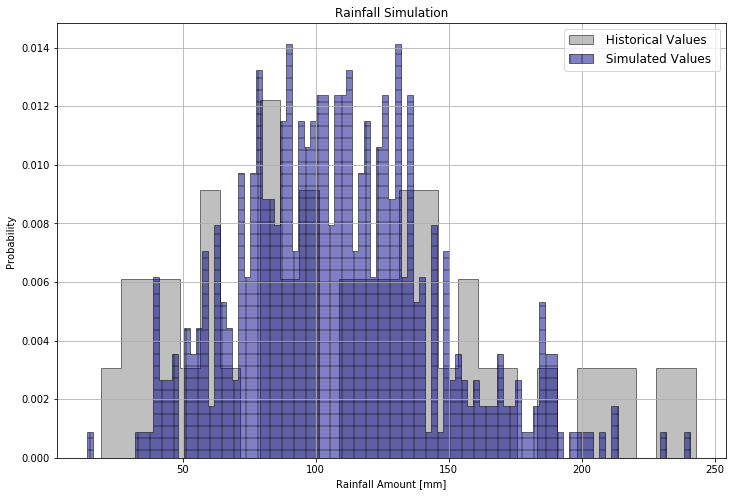

DescribeResult(nobs=500, minmax=(14.13268974907386, 240.5326447467337), mean=108.60325463331382, variance=1359.6570684639853, skewness=0.4891941103397802, kurtosis=0.28811201896674854)


In [396]:
myPlot= optionRainfallCalculator_model_Plot(iterations=500,
                           model='Model 3', 
                           startDate='2017-04-01',
                           transitionsParametersDry= transitionsParametersDry ,
                           transitionsParametersWet = transitionsParametersWet,
                           amountParametersGamma=amountParametersGamma,
                           fittedGamma = fittedGamma,
                           optionMonthTerm=1)

In [352]:
historicalMonths.

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1972,72.1,25.3,52.1,161.4,122.2,58.1,37.5,39.6,17.4,66.8,105.3,29.1
1973,2.9,3.8,50.1,39.3,75.0,59.5,55.1,57.4,130.3,115.4,105.8,117.3
1974,79.6,100.0,28.5,83.8,61.3,65.5,15.8,46.8,91.8,100.3,150.6,24.0
1975,5.5,32.2,130.0,57.9,105.3,56.4,60.3,52.2,55.1,160.8,70.7,77.9
1976,31.2,59.9,117.5,112.3,114.7,57.2,19.4,34.7,47.3,140.0,81.6,49.5
1977,9.1,20.4,72.2,86.4,34.1,15.9,52.0,52.9,115.7,120.4,82.3,26.9
1978,5.6,25.0,55.7,121.4,73.5,71.2,52.9,12.9,66.4,102.9,47.4,30.2
1979,27.5,44.8,55.0,137.3,84.5,77.5,64.8,113.5,86.3,133.4,141.7,25.4
1980,28.2,62.8,30.9,46.2,39.5,76.8,10.7,39.8,48.3,63.6,50.7,102.2
1981,2.5,27.3,13.7,174.6,202.1,78.1,23.7,34.4,51.1,113.4,111.8,25.5


In [403]:
# Load historical month rainfall.
file = open('../../datasets/historicalMonths.pk','rb')
historicalMonths = pickle.load(file)
file.close()

def plotRainfallDistributionMonthLine(rainfallSimulated,month,year,colorP):
  
    # Create Figure.
    fig = plt.figure(figsize=(12, 8))

    # Plot Histogram
    #plt.hist(historicalMonths.iloc[year,month-1].values,facecolor='grey',bins=30, density=True,
    #       histtype='stepfilled', edgecolor = 'black' , hatch = '', alpha = 0.5, label=' Historical Values')

    plt.axvline(x=historicalMonths.iloc[year-historicalMonths.index[0],month-1], ymin=-1, ymax=1, color='black', linestyle='--', lw=3, label='Real Value')
    
    # Plot histogram.
    plt.hist(rainfallSimulated,facecolor=colorP,bins=100, density=True,
           histtype='stepfilled', edgecolor = 'black' , hatch = '+', alpha = 0.5, label=' Simulated Values ')
    


    # Add axis names.
    plt.title('Rainfall Simulation')
    plt.xlabel('Rainfall Amount [mm]')
    plt.ylabel('Probability ')
    plt.grid()
    plt.legend(fontsize='large')
    plt.show()

def optionRainfallCalculator_model_PlotLine(iterations, model , startDate, transitionsParametersDry, transitionsParametersWet, amountParametersGamma, fittedGamma, optionMonthTerm):
  
    ## Generates initial conditions.
  
    # Defines initial state based on proportions.
    successProbability = 0.5
    initialState = bernoulli.rvs(successProbability) 

    # Calculates initial prepicipitation.
    if initialState == 1:
        initialPrep = 1.0
    else:
        initialPrep = 0.0

    ## Create dataframe to simulate. 
    simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)

    ## Run all iterations.
    if model == 'Model 1':
        ## Create dataframe to simulate. 
        simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)

        daysNumber = 30 
        ## Run all iterations.
        rainfallPerIteration = totalRun_1(daysNumber,startDate,initialState, monthTransitionsProb,fittedGamma,iterations)
        colorP = 'darkred'

    elif model == 'Model 2':
        ## Create dataframe to simulate. 
        simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)

        ## Run all iterations.
        rainfallPerIteration = totalRun_2(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, fittedGamma,iterations)
        colorP = 'darkgreen'
        
    elif model == 'Model 3':
        ## Create dataframe to simulate. 
        simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)

        ## Run all iterations.
        rainfallPerIteration = totalRun_3(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)
        colorP = 'darkblue'
        
    else:
        print('The requested model does not exist.')
  
    ## Plot histogram.
    month = datetime.datetime.strptime(startDate,'%Y-%m-%d').month
    year = datetime.datetime.strptime(startDate,'%Y-%m-%d').year

    plotRainfallDistributionMonthLine(rainfallPerIteration,month,year,colorP)

    ## Print Statistics.

    print(stats.describe(rainfallPerIteration))

    return rainfallPerIteration

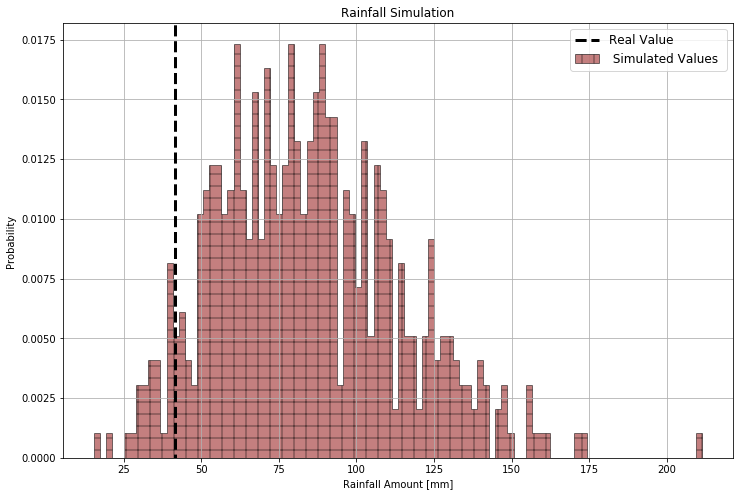

DescribeResult(nobs=500, minmax=(15.245508191783369, 211.45187788525593), mean=84.1125424904268, variance=864.4528437172362, skewness=0.5120411994799418, kurtosis=0.3051192315710538)


In [420]:
myPlot= optionRainfallCalculator_model_PlotLine(iterations=500,
                           model='Model 1', 
                           startDate='2014-06-01',
                           transitionsParametersDry= transitionsParametersDry ,
                           transitionsParametersWet = transitionsParametersWet,
                           amountParametersGamma=amountParametersGamma,
                           fittedGamma = fittedGamma,
                           optionMonthTerm=1)

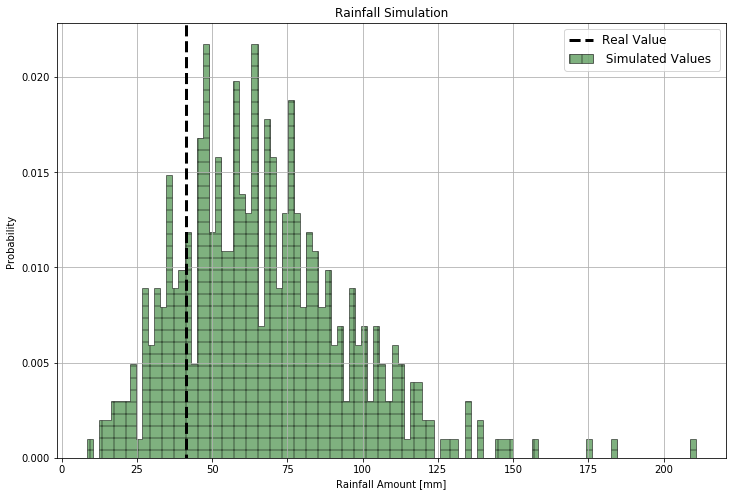

DescribeResult(nobs=500, minmax=(8.477428280097156, 210.68234826114622), mean=67.23034091744616, variance=801.9611253384472, skewness=0.8679467771208987, kurtosis=1.6861255435882532)


In [421]:
myPlot= optionRainfallCalculator_model_PlotLine(iterations=500,
                           model='Model 2', 
                           startDate='2014-06-01',
                           transitionsParametersDry= transitionsParametersDry ,
                           transitionsParametersWet = transitionsParametersWet,
                           amountParametersGamma=amountParametersGamma,
                           fittedGamma = fittedGamma,
                           optionMonthTerm=1)

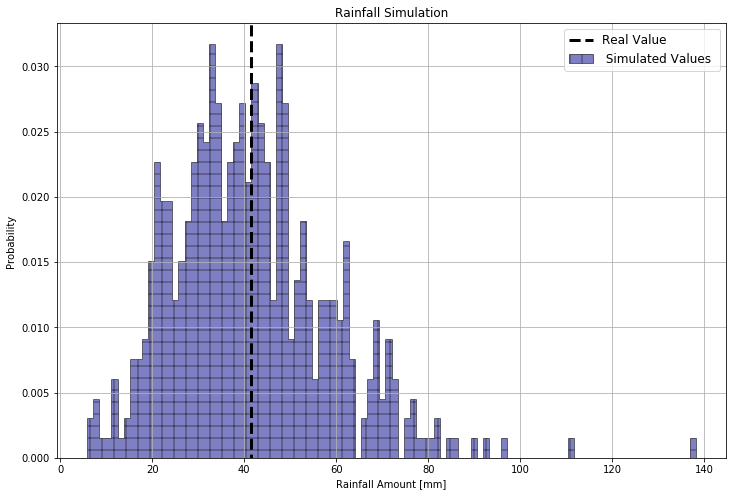

DescribeResult(nobs=500, minmax=(5.885724612757888, 138.19114873340882), mean=41.23469256586913, variance=285.88410460165403, skewness=0.8936726850478535, kurtosis=2.2355677921567194)


In [422]:
myPlot= optionRainfallCalculator_model_PlotLine(iterations=500,
                           model='Model 3', 
                           startDate='2014-06-01',
                           transitionsParametersDry= transitionsParametersDry ,
                           transitionsParametersWet = transitionsParametersWet,
                           amountParametersGamma=amountParametersGamma,
                           fittedGamma = fittedGamma,
                           optionMonthTerm=1)

In [430]:
def optionRainfallCalculator_df(iterations, model , startDate, transitionsParametersDry, transitionsParametersWet, amountParametersGamma, fittedGamma, optionMonthTerm):
  
    ## Generates initial conditions.
  
    # Defines initial state based on proportions.
    successProbability = 0.5
    initialState = bernoulli.rvs(successProbability) 

    # Calculates initial prepicipitation.
    if initialState == 1:
        initialPrep = 1.0
    else:
        initialPrep = 0.0

    ## Create dataframe to simulate. 
    simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)

    ## Run all iterations.
    if model == 'Model 1':
        ## Create dataframe to simulate. 
        simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)

        daysNumber = 30 
        ## Run all iterations.
        rainfallPerIteration = totalRun_1(daysNumber,startDate,initialState, monthTransitionsProb,fittedGamma,iterations)
        colorP = 'darkred'

    elif model == 'Model 2':
        ## Create dataframe to simulate. 
        simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)

        ## Run all iterations.
        rainfallPerIteration = totalRun_2(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, fittedGamma,iterations)
        colorP = 'darkgreen'
        
    elif model == 'Model 3':
        ## Create dataframe to simulate. 
        simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = startDate, initialState = initialState , initialPrep =  initialPrep, ensoForecast = ensoForecast, optionMonthTerm = optionMonthTerm)

        ## Run all iterations.
        rainfallPerIteration = totalRun_3(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)
        colorP = 'darkblue'
        
    else:
        print('The requested model does not exist.')
  
    ## Plot histogram.
    month = datetime.datetime.strptime(startDate,'%Y-%m-%d').month
    year = datetime.datetime.strptime(startDate,'%Y-%m-%d').year

    #plotRainfallDistributionMonthLine(rainfallPerIteration,month,year,colorP)

    ## Print Statistics.

    #print(stats.describe(rainfallPerIteration))

    return rainfallPerIteration

In [436]:
columnNames=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
vv = pd.DataFrame(columns=columnNames)

for i in range(1,10):
    start = 2005*1 
    end = start+11
    for year in range(start,end):
        vv.loc[year] = [np.mean(optionRainfallCalculator_df(iterations=1,
                               model='Model 3', 
                               startDate=str(year)+'-'+'{:02}'.format(strptime(month,'%b').tm_mon)+'-01',
                               transitionsParametersDry= transitionsParametersDry ,
                               transitionsParametersWet = transitionsParametersWet,
                               amountParametersGamma=amountParametersGamma,
                               fittedGamma = fittedGamma,
                               optionMonthTerm=1)) for x in columnNames ]

In [437]:
vv

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2005,67.311399,73.543899,38.239166,114.547772,42.827590,41.253923,101.275461,27.224677,38.407360,41.970349,100.912073,58.310056
2006,73.189072,40.420366,43.862336,66.136979,47.524745,49.483358,43.286959,61.909679,28.661185,51.878430,45.302837,42.224262
2007,53.531029,70.844907,70.245019,46.757877,69.877268,80.085006,52.915332,76.197708,85.514245,51.125629,60.813066,72.861943
2008,60.492435,44.835012,54.328539,53.843984,37.100818,41.568179,35.666293,106.964513,54.925564,79.679076,47.153827,42.951405
2009,17.335202,21.556064,36.920860,48.090586,37.738125,35.779494,63.580734,19.126209,20.694319,19.198963,28.592003,32.109501
2010,76.697347,59.250178,67.541506,52.573290,83.314233,66.041494,48.990845,60.481970,62.819568,33.493367,59.693444,71.919446
2011,38.970112,85.282872,46.441182,79.267610,52.948428,52.424193,62.178981,82.027532,33.127050,35.428838,52.302854,61.057084
2012,38.957446,27.304865,18.278046,38.271904,33.276832,40.777878,35.953656,31.387250,26.213604,28.136104,40.446053,38.213664
2013,53.330869,48.598284,103.561479,48.976088,47.929169,55.038483,85.087743,39.903386,77.807983,37.841151,49.021304,50.486965
2014,41.282638,51.998925,20.092936,30.199524,16.608704,37.539778,36.662627,88.929747,59.597570,37.612104,28.868664,24.809344


Text(0.5, 0, 'Month')

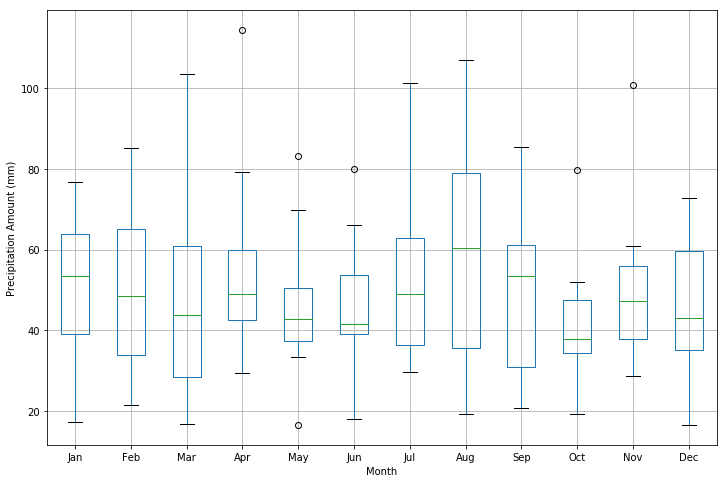

In [438]:
plt.figure(figsize=(12,8))
vv.boxplot()
plt.ylabel('Precipitation Amount (mm)')
plt.xlabel('Month')